# Neural Networks

In this assignment we will implement the [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm for a neural network using a computational graph. 

Each node in the network has a reference to is ancestor (not successor nodes), as follows:
![Network configuration](resource/assignment-9.png)

We will be implementing the nodes defined above, including their ```forward``` and ```backward``` passes. In the forward pass, the node reads its input and calculates an ```activation``` which it then retains for the next layer. In the backward pass, the partial derivative of output with respect to a variable is calculated in the ```pderv``` function, recursively through the graph. Nodes are connected by setting the respecitve back pointers in the ```connect``` function.

In [1]:
from lib.basic import *
import matplotlib.pyplot as plt
import random

In [2]:
def concentric_dataset():
    data = []
    with open("resource/concentric.tsv") as f:
        for l in f.readlines():
            x, y, label = l.strip().split("\t")
            data.append({"features": {"x1": (float(x) / 3), "x2": (float(y) / 3)}, "label": -(2 * int(label) - 1)})
    return data

def generate_synthetic_data():
    means = [[-0.5, -0.5], [0.5, 0.5]]
    labels = [-1.0, 1.0]
    res = []
    rand = random.Random()
    rand.seed(293891)
    for i in range(5000): 
        mx = means[i % 2]
        lbl = labels[i % 2]
        res.append({"features": {"x1": (rand.normalvariate(0, 1) * 0.2) + mx[0],
                                 "x2": (rand.normalvariate(0, 1) * 0.2) + mx[1]},
                    "label": lbl})
    return res

def xor_dataset():
    means = [[-0.5, -0.5], [0.5, -0.5], [-0.5, 0.5], [0.5, 0.5]]
    labels = [-1.0, 1.0, 1.0, -1.0]
    res = []
    rand = random.Random()
    rand.seed(293891)
    for i in range(500): 
        mx = means[i % 4]
        lbl = labels[i % 4]
        res.append({"features": {"x1": (rand.normalvariate(0, 1) * 0.2) + mx[0],
                                 "x2": (rand.normalvariate(0, 1) * 0.2) + mx[1]},
                    "label": lbl})
    return res


two_means_data = generate_synthetic_data()
concentric_circle_data = concentric_dataset()
xor_data = xor_dataset()

## Question 1: Input

Implement the ```Input``` node which contains a single column of a vector. The value of the variable held by an ```Input``` object is set by calling the ```activation``` accessor directly. In previous assignments we specify a row in a dataset as a hash of features, such as the following:

```ruby
example = {"features" => {"x1" => 1.0, "x2" => 3.0}}
```

Now, the ```Input``` node holds the value of a single column. Each node has a name which represents the variable is knows about. The above statement is equivalent to initializing two ```Input``` nodes once as follows:

```ruby
x1 = Input.new "x1"
x2 = Input.new "x2"
```

Each subsequent example sets the activation value directly, as follows:

```ruby
x1.activation = 1.0
x2.activation = 3.0
```

## Question 1.1 (5 points)

Implement the ```forward``` method which calculates the activation and stores it in a member variable.

In [3]:
def connect(src, dst):
    dst.back_net[src.name] = src
    
class Input:
    """
    attr_accessor :activation
    attr_reader :back_net
    attr_reader :name
    """
  
    def __init__(self, name):    
        self.name = name
        self.back_net = None
        self.activation = None

    def forward(self):
        # BEGIN YOUR CODE
        return self.activation
        # END YOUR CODE

In [4]:
def test_input_forward():
    i = Input("x1")
    assert(i)
    assert(not i.activation)

    i.activation = 1.0
    assert_equal(1.0, i.activation)
    assert_equal(1.0, i.forward())

    i.activation = 2.0
    assert_equal(2.0, i.forward())

test_input_forward()

## Question 1.2 (5 points)

Implement the ```pderv``` method which calculates partial derivative of the input with respect to ```name```. That is, this method calculates:

$\begin{align}
\frac{\partial x}{\partial \text{name}}
\end{align}$

where $x$ is an ```Input``` object.

There are two possible derivative values here, when the ```name``` is the variable represented by the input node and when it isn't.

In [5]:
def pderv(self, name):
    # BEGIN YOUR CODE
    return 1.0 if name == self.name else 0.0
    # END YOUR CODE

Input.pderv = pderv

In [6]:
def test_input_pderv():
    i = Input("x")
    i.activation = 7.1
    assert_equal(1.0, i.pderv("x"))
    assert_equal(0.0, i.pderv("another_variable"))

test_input_pderv()

## Question 2.1 (5 points)

Implement the $L_2$ loss function assuming that there is an ```incoming``` node whose ```activation``` is known. Feedback is provided by explicitly setting ```feedback```.

In [7]:
class L2Loss:
    """
    attr_reader :activation
    attr_reader :back_net
    attr_reader :name
    attr_accessor :feedback
    """

    def __init__(self):
        self.back_net = {}
        self.activation = None  

    def incoming(self):
        values = list(self.back_net.values())
        return values[-1] if values else None

    def forward(self):
        # BEGIN YOUR CODE
        self.activation = self.incoming().forward()
        return self.activation
        # END YOUR CODE

In [8]:
def test_l2loss_forward():
    l2loss = L2Loss()
    i = Input("x1")
    connect(i, l2loss)

    i.activation = 7.5
    assert_in_delta(7.5, l2loss.forward(), 1e-4)
    assert_in_delta(7.5, l2loss.activation, 1e-4)

test_l2loss_forward()

## Question 2.2 (5 points)

Implement the $L_2$ loss fuction based on the ```activation``` and ```feedback```.

In [9]:
def loss(self):
    # BEGIN YOUR CODE
    return (self.activation - self.feedback) ** 2 / 2
    # END YOUR CODE

L2Loss.loss = loss

In [10]:
def test_l2loss_loss():
    l2loss = L2Loss()
    i = Input("x1")
    connect(i, l2loss)

    i.activation = 7.5
    l2loss.forward()
    l2loss.feedback = 1.0
    assert_in_delta(21.125, l2loss.loss(), 1e-4)

test_l2loss_loss()

## Question 2.3 (5 points)

Implement the partial derivative function $L_2$ loss fuction based on the ```activation``` and ```feedback```. 

In [11]:
def pderv(self, fname):
    # BEGIN YOUR CODE
    return (self.activation - self.feedback) * self.incoming().pderv(fname)
    # END YOUR CODE

L2Loss.pderv = pderv

In [12]:
def test_l2loss_pderv():
    l2loss = L2Loss()
    i = Input("x1")
    connect(i, l2loss)

    i.activation = 7.5
    l2loss.forward()
    l2loss.feedback = 1.0
    assert_in_delta(6.5, l2loss.pderv("x1"), 1e-4)
    assert_in_delta(0.0, l2loss.pderv("some_other_variable"), 1e-4)

test_l2loss_pderv()

## Question 2.4 (5 points)

Implement log loss, where the activation is assumed to take the sigmoid of the input. The partial derivative uses the same form as in [Assignment 4](assignment-4/assignment-4.ipynb).

In [13]:
class LogLoss:
    """
    attr_reader :activation
    attr_reader :back_net
    attr_reader :name
    attr_accessor :feedback
    """

    def __init__(self):
        self.back_net = {}
        self.activation = None

    def incoming(self):
        values = list(self.back_net.values())
        return values[-1] if values else None

    def forward(self):
        # BEGIN YOUR CODE
        self.activation = 1 / (1 + math.exp(-self.incoming().forward()))
        return self.activation
        # END YOUR CODE

    def pderv(self, fname):
        # BEGIN YOUR CODE
        y = 1.0 if self.feedback > 0 else 0.0
        return (self.activation - y) * self.incoming().pderv(fname)
        # END YOUR CODE

    def loss(self):
        # BEGIN YOUR CODE
        y = 1.0 if self.feedback > 0 else 0.0
        return -(y * math.log(self.activation) + (1 - y) * math.log(1 - self.activation))
        # END YOUR CODE

In [14]:
def test_logloss():
    logloss = LogLoss()
    i = Input("x1")
    connect(i, logloss)

    i.activation = 0.77
    assert_in_delta(0.6835208937, logloss.forward(), 1e-4)

    logloss.feedback = 1
    assert_in_delta(-0.3164791063, logloss.pderv("x1"), 1e-4)
    assert_in_delta(0.3804980545, logloss.loss(), 1e-4)

test_logloss()

## Question 3.1 (5 points)

Implement the Sigmoid activation function. Given the incoming value $x$, the ```forward``` function calculates ```@activation``` as the sigmoid of x, or:

$
\begin{align}
\sigma(x) = \frac{1}{1+ e^{-x}}
\end{align}
$

In the ```pderv``` function, calculate the partial derivative of the activation function and apply the derivative to the ```back_net``` variables. 

In [15]:
class Sigmoid:
    """
    attr_reader :activation
    attr_reader :name
    attr_reader :back_net
    """

    def __init__(self, name = "_"):
        self.name = name
        self.back_net = {}

    def incoming(self):
        values = list(self.back_net.values())
        return values[-1] if values else None

    # BEGIN YOUR CODE
    def forward(self):
        self.activation = 1 / (1 + math.exp(- self.incoming().forward()))
        return self.activation

    def pderv(self, fname):
        return (self.activation - self.activation ** 2) * self.incoming().pderv(fname)
    # END YOUR CODE

In [16]:
def test_sigmoid():
    i = Input("x1")
    i.activation = 0.0

    sig = Sigmoid("s")
    connect(i, sig)

    s1 = sig.forward()
    assert_in_delta(0.5, s1, 1e-4, "sig(0.5)")
    p1 = sig.pderv("x1")
    assert_in_delta(0.25, p1, 1e-4, "pderv(0.5)")


    i.activation = 0.775
    s2 = sig.forward()
    assert_in_delta(0.6846015003, s2, 1e-4, "sig(0.775)")
    p2 = sig.pderv("x1")
    assert_in_delta(0.2159222861, p2, 1e-4, "pderv(0.775)")

    p3 = sig.pderv("some_other_variable")
    assert_in_delta(0.0, p3, 1e-4, "pderv(other)")

test_sigmoid()

## Question 3.2 (5 points)

Implement the ReLU activation function. Given the incoming value $x$, the ```forward``` function calculates ```@activation``` as a function of x, as follows:

$
\begin{align}
\text{ReLU}(x) = \max \left\{ 0, x \right\}
\end{align}
$

In the ```pderv``` function, calculate the partial derivative of the activation function and apply the derivative to the ```back_net``` variables. 

In [17]:
class ReLU:
    """
    attr_reader :activation
    attr_reader :name
    attr_reader :back_net
    """
    def __init__(self, name):
        self.name = name
        self.back_net = {}

    def incoming(self):
        values = list(self.back_net.values())
        return values[-1] if values else None

    # BEGIN YOUR CODE
    def forward(self):
        self.activation = max(0.0, self.incoming().forward())
        return self.activation

    def pderv(self, fname):
        return (0.0 if self.activation <= 0 else 1.0) * self.incoming().pderv(fname)
    # END YOUR CODE

In [18]:
def test_relu():
    i = Input("x1")
    i.activation = 0.5

    relu = ReLU("s")
    connect(i, relu)

    s1 = relu.forward()
    assert_in_delta(0.5, s1, 1e-4, "relu(0.5)")
    p1 = relu.pderv("x1")
    assert_in_delta(1.0, p1, 1e-4, "pderv(0.5)")


    i.activation = -0.775
    s2 = relu.forward()
    assert_in_delta(0.0, s2, 1e-4, "relu(-0.775)")
    p2 = relu.pderv("x1")
    assert_in_delta(0.0, p2, 1e-4, "pderv(-0.775)")

    p3 = relu.pderv("some_other_variable")
    assert_in_delta(0.0, p3, 1e-4, "pderv(other)")

test_relu()

## Question 4.1 (5 points)

The ```LinearUnit``` calculates the inner product between the input activations and an internal weight vector. The weight vector is stored as a reference that is common across the whole network. Therefore, each feature name needs to be unique. 

The diagram below shows the network configuration for Logstic Regression. Multiple ```Input``` units are connected to the ```LinearUnit```, which connected to the ```Sigmoid``` activation function. The activation function is then connected to the ```L2Loss``` output node. 

![Network configuration](resource/assignment-9-Page-2.png)

In the ```forward``` function, each input node in the ```back_net``` has an activation. Assume there is a pre-defined weight for the bias.

In [19]:
class LinearUnit:
    """
    attr_reader :activation
    attr_reader :back_net
    attr_reader :name
    """

    def __init__(self, name, weights):
        self.name = name
        self.weights = weights
        self.back_net = {}    

    def n(self, fname):
        return ".".join([self.name, fname])

    def forward(self):
        if self.n("bias") not in self.weights:
            self.weights[self.n("bias")] = 0.7 
        self.activation = self.weights[self.n("bias")]
        # BEGIN YOUR CODE
        for name, incoming in self.back_net.items():
            if self.n(name) not in self.weights:
                self.weights[self.n(name)] = 0.7
            self.activation += self.weights[self.n(name)] * incoming.forward()
        # END YOUR CODE
        return self.activation

In [20]:
def test_linear_forward():
    weights = {} # default value 0.7
    linear = LinearUnit("f", weights)
    assert(linear)
    assert(not linear.back_net)

    i = Input("x1")
    i.activation = 0.2

    connect(i, linear)
    assert_equal(i, linear.back_net["x1"])

    assert_in_delta(0.2 * 0.7 + 0.7, linear.forward(), 1e-4)
    assert_in_delta(0.7, weights.get("f.x1", 0.7), 1e-4)
    assert_in_delta(0.7, weights.get("f.bias", 0.7), 1e-4)
    #assert_equal(2, len(weights))

test_linear_forward()

## Question 4.2 (5 points)

The partial derivative function for the ```LinearUnit``` has two cases. In the ```pderv_weights``` below, calculate the partial derivative for weight variables.

In [21]:
def pderv_weights(self, name):
    # BEGIN YOUR CODE
    name = name[name.index(".") + 1 :]
    if name == "bias":
        res = 1.0
    else:
        if name not in self.back_net:
            #print("\t".join([self.name, name, self.back_net.keys()])
            raise Exception("not in backnet")
        res = self.back_net[name].forward()
    return res
    # END YOUR CODE

def pderv(self, name):
    return self.pderv_weights(name)

LinearUnit.pderv = pderv
LinearUnit.pderv_weights = pderv_weights

In [22]:
def test_linear_pderv_weights():
    weights = {}
    linear = LinearUnit("f", weights)
    assert(linear)

    i = Input("x1")
    i.activation = 0.2  
    connect(i, linear)

    i.forward()
    act = linear.forward()

    assert_in_delta(0.2, linear.pderv_weights("f.x1"), 1e-4)
    assert_in_delta(1.0, linear.pderv_weights("f.bias"), 1e-4)

test_linear_pderv_weights()

## Question 4.3 (5 points)

Considering the dataset below, copy **your** ```StochasticGradientDescent``` and train a logistic regression model. Make two changes to your trainer:

1. Keep learning rate is fixed, i.e., do not try to reduce the learning rate.
1. Divide by the size of the mini-batch in the SGD not in gradient calculation

The ```LogisticRegression``` function should implement these steps just like every other model we used:

1. ```forward```: Calls the forward function for the input, linear unit, activation, and output nodes.
1. ```func```: Calculate the total $L_2$ loss under a sigmoid activation function for all examples in the dataset.
1. ```grad```: Calculate the total gradient vector for all parameters in the function. im


Because the implementation above takes one row at a time, it will call the forward operation again in ```func``` and ```grad```.


Paste **your** implementation of the AUCMetric class here.

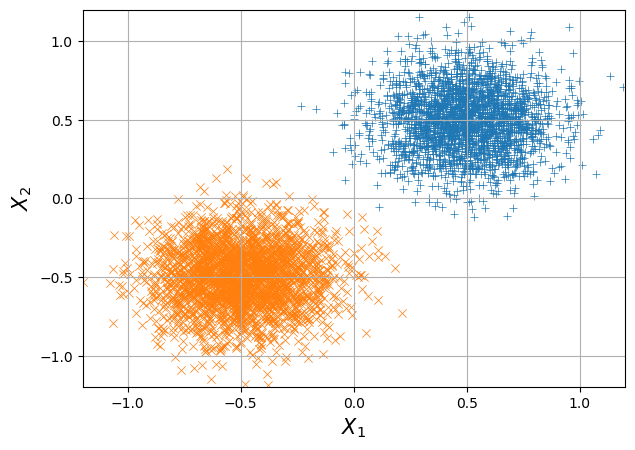

In [23]:
def plot_dataset(examples):
    pos_x1 = [r["features"]["x1"] for r in examples if r["label"] > 0]
    pos_x2 = [r["features"]["x2"] for r in examples if r["label"] > 0]
    neg_x1 = [r["features"]["x1"] for r in examples if r["label"] <= 0]
    neg_x2 = [r["features"]["x2"] for r in examples if r["label"] <= 0]

    fig, ax = plt.subplots(figsize=(7, 5), dpi=100, facecolor='w', edgecolor='k')

    """
    for example in examples:
        x1.append(example["features"]["x1"])
        x2.append(example["features"]["x2"])
        target.append(example["label"])
    ax.scatter(x1, x2, marker='+', c=target, lw = 0.5)
    """
    ax.scatter(pos_x1, pos_x2, marker='+', lw = 0.5)
    ax.scatter(neg_x1, neg_x2, marker='x', lw = 0.5)
    ax.set_xlabel(r'$X_1$', fontsize=15)
    ax.set_ylabel(r'$X_2$', fontsize=15)
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    ax.grid(True)
    #fig.tight_layout()
    plt.show()

plot_dataset(two_means_data)

In [24]:
class StochasticGradientDescent:
    # BEGIN YOUR CODE
    """
    attr_reader :weights
    attr_reader :objective
    """
    def __init__(self, obj, w_0, lr = 0.0001):
        self.objective = obj
        self.weights = w_0
        self.n = 1.0
        self.lr = lr

    def update(self, x):
        #lr = @lr / Math.sqrt(@n)
        self.n += 1
        grad = self.objective.grad(x, self.weights)
        for key in grad:
            self.weights[key] = self.weights.get(key, 0.0) - self.lr * grad[key]
        self.objective.adjust(self.weights)
    # END YOUR CODE

In [25]:
class LogisticRegression:
    def __init__(self, weights):
        self.x1 = Input("x1")
        self.x2 = Input("x2")
        self.inner = LinearUnit("wx", weights)
        self.sig = Sigmoid("sig")
        self.out = L2Loss()

        connect(self.x1, self.inner)
        connect(self.x2, self.inner)
        connect(self.inner, self.sig)
        connect(self.sig, self.out)

    def predict(self, examples):
        return [self.forward(example) for example in examples]

    def forward(self, example):
        # BEGIN YOUR CODE
        self.x1.activation = example["features"]["x1"]
        self.x2.activation = example["features"]["x2"]
        self.inner.forward()
        self.sig.forward()
        self.out.feedback = example.get("label", None) # for plot_decision_boundary
        return self.out.forward()
        #END YOUR CODE

    def func(self, examples, weights):
        # BEGIN YOUR CODE
        total_lose = 0.0
        for example in examples:
            self.forward(example)
            total_lose += self.out.loss()
        return total_lose / len(examples)
        #END YOUR CODE

    def grad(self, examples, weights):
        g = {}

        # BEGIN YOUR CODE
        for example in examples:
            self.forward(example)
            for key in weights:
                g[key] = g.get(key, 0.0) + self.out.pderv(key)
        for key, val in g.items():
            g[key] = val / len(examples)
        #END YOUR CODE
        return g

    def adjust(self, weights):
        pass


In [26]:
def test_logistic_regression(data):
    cumulative_loss = 0.0
    i = 0
    weights = {}
    obj = LogisticRegression(weights)
    sgd = StochasticGradientDescent(obj, weights, 0.02)
    for epoch in range(5):
        for j in range(0, len(data), 20):
            batch = data[j : j + 20]
            sgd.update(batch)
            cumulative_loss += obj.func(batch, sgd.weights)
            i += 1
            if i % 100 == 1:
                print(cumulative_loss / i)

    print(weights)  
    predictions = obj.predict(data)
    scores = [[score, 1 if data[index]["label"] > 0 else 0] for index, score in enumerate(predictions)]
    auc = AUCMetric().apply(scores)
    print("AUC: {%f}" % auc)

    assert(0.5 >= (cumulative_loss / i))
    assert(auc > 0.9)

    return obj

trained_lr_model = test_logistic_regression(two_means_data)

0.5792065469308132
0.5299535182415086
0.49395535943669006
0.46685925312077164
0.4464336527140039
0.4298342637622472
0.41660534302954455
0.40544725370519535
0.3960819080348444
0.3882554771355385
0.38134832511291483
0.3753572419034074
0.3699497251037064
{'wx.bias': -0.7235678256514835, 'wx.x1': 1.8998566603122324, 'wx.x2': 1.9089291498552605}
AUC: {1.000000}


### Observe
The following plot of the decision boundary should show a higher values for the positive class.

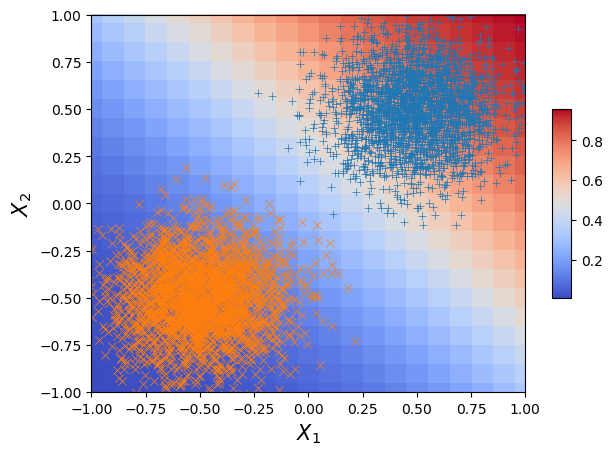

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from matplotlib.image import NonUniformImage
def plot_decision_boundary(data, model):
    pos_x1 = [r["features"]["x1"] for r in data if r["label"] > 0]
    pos_x2 = [r["features"]["x2"] for r in data if r["label"] > 0]
    neg_x1 = [r["features"]["x1"] for r in data if r["label"] <= 0]
    neg_x2 = [r["features"]["x2"] for r in data if r["label"] <= 0]

    """
    # 3D
    X = np.arange(-1, 1, 0.1)
    Y = np.arange(-1, 1, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.ndarray(shape=(len(X),len(X[0])), dtype=float)
    for i in range(len(X)):
        for j in range(len(X[0])):
            x1 = X[i][j]
            x2 = Y[i][j]
            Z[i][j] = trained_lr_model.predict([{"features": {"x1": x1, "x2": x2}}])[0] - 0.5

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
    ax.set_zlim(-1.01, 1.01)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    #ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2)
    """

    f_x1 = np.linspace(-1, 1, 21)
    f_x2 = np.linspace(-1, 1, 21)
    f_z = np.ndarray(shape=(len(f_x1),len(f_x2)), dtype=float)

    for i in range(len(f_x1)):
        for j in range(len(f_x2)):
            x1 = f_x1[i]
            x2 = f_x2[j]
            f_z[i][j] = model.predict([{"features": {"x1": x1, "x2": x2}}])[0]
    fig, ax = plt.subplots(figsize=(7, 5), dpi=100, facecolor='w', edgecolor='k')
    im = NonUniformImage(ax, extent=(-1, 1, -1, 1), cmap=cm.coolwarm)
    im.set_data(f_x1, f_x2, f_z)
    ax.images.append(im)
    ax.scatter(pos_x1, pos_x2, marker='+', lw = 0.5)
    ax.scatter(neg_x1, neg_x2, marker='x', lw = 0.5)
    
    fig.colorbar(im, shrink=0.5, aspect=10)
    ax.set_xlabel(r'$X_1$', fontsize=15)
    ax.set_ylabel(r'$X_2$', fontsize=15)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

plot_decision_boundary(two_means_data, trained_lr_model)

## Question 5.1 (5 points)

Neural networks connect multiple linear units together. Testing that this works. No additional code needed here, just another test.

In [28]:
def test_hidden_forward():
    weights = {
        "h0.x1": 1.0, "h0.bias": 0.0,
        "h1.x1": 2.0, "h1.bias": 0.0,
        "f0.h0": 3.0, "f0.h1": 4.0, "f0.bias": 0.0
    }
    h0 = LinearUnit("h0", weights)
    h1 = LinearUnit("h1", weights)
    f0 = LinearUnit("f0", weights)

    i = Input("x1")  
    i.activation = 0.2

    connect(i, h0)
    connect(i, h1)

    connect(h0, f0)
    connect(h1, f0)

    i.forward()
    h0.forward()
    h1.forward()
    f0.forward()

    assert_in_delta(0.2, h0.activation, 1e-4, "h0")
    assert_in_delta(0.4, h1.activation, 1e-4, "h1")
    assert_in_delta(0.2 * 3 + 0.4 * 4, f0.activation, 1e-4, "f0")

test_hidden_forward()

## Question 5.2 (5 points)

Implement the backpropagation function for the linear unit when the variable requested is _not_ one of the weights. This function is what makes the backpropagation algorithm work. We will also overwrite the ```pderv``` function here to use the two cases.

In [29]:
def pderv_back(self, name):
    # BEGIN YOUR CODE
    res = 0.0
    for node_name, node in self.back_net.items():
        pd_name = self.n(node_name)
        res += self.weights[pd_name] * node.pderv(name)
    # print(("\t").join(["pderv_back", @name, name, res.to_s]))
    return res
    # END YOUR CODE

  
  
def pderv(self, name):
    if name.startswith(self.name + ".") and name in self.weights:
        return self.pderv_weights(name)
    else:
        return self.pderv_back(name)

LinearUnit.pderv_back = pderv_back
LinearUnit.pderv = pderv

In [30]:
def test_hidden_backward():
    weights = {
        "h0.x1": 1.5, "h0.bias": 0.0,
        "h1.h0": 2.0, "h1.bias": 0.0,
        "h2.h0": 3.0, "h2.bias": 0.0,    
        "h3.h1": 4.0, "h3.h2": 5.0, "h3.bias": 0.0
    }

    h0 = LinearUnit("h0", weights)
    h1 = LinearUnit("h1", weights)
    h2 = LinearUnit("h2", weights)
    h3 = LinearUnit("h3", weights)

    i = Input("x1")  
    i.activation = 0.2

    connect(i, h0)

    connect(h0, h1)
    connect(h0, h2)
    connect(h1, h3)
    connect(h2, h3)

    for n in [i, h0, h1, h2, h3]:
        n.forward()

    assert_in_delta(0.2, h0.pderv("h0.x1"), 1e-4, "h0")
    assert_in_delta(0.3, h1.pderv("h1.h0"), 1e-4, "h1")
    assert_in_delta(0.3, h2.pderv("h2.h0"), 1e-4, "h2")
    assert_in_delta(4.0 * (2 * 0.2) + 5 * (3 * 0.2), h3.pderv("h0.x1"), 1e-4, "h3")

test_hidden_backward()

In [31]:
def test_91192b():
    w1 = {"v.x1": 6.21285855261965, "v.x2": 5.89754417523916, "v.bias": -28.0932043104677}
    w2 = {"t.x1": -6.47151832422693, "t.x2": -6.25964370262662, "t.bias": 21.3658877452187}
    w3 = {"u.z1": 5.79180358051235, "u.z2": 5.7240375033176, "u.bias": -2.83249422973696}

    x1 = Input("x1")
    x2 = Input("x2")

    v = LinearUnit("v", w1)
    z1 = Sigmoid("z1")
    connect(x1, v)
    connect(x2, v)
    connect(v, z1)

    t = LinearUnit("t", w2)
    z2 = Sigmoid("z2")
    connect(x1, t)
    connect(x2, t)
    connect(t, z2)

    u = LinearUnit("u", w3)
    yhat = LogLoss()

    connect(z1, u)
    connect(z2, u)
    connect(u, yhat)

    x1.activation = 1.5
    x2.activation = 2.0

    x1.forward; x2.forward
    print("v(x) = %.4f" % v.forward())
    print("z1(v) = %.4f" % z1.forward())
    print("t(x) = %.4f" % t.forward())
    print("z2(t) = %.4f" % z2.forward())
    print("u(z) = %.4f" % u.forward())
    print("yhat(u) = %.4f" % yhat.forward())
    assert_in_delta(0.2449, yhat.activation, 1e-3)

    print("Calculate d[j]/dw11")
    yhat.feedback = 1
    print("d[j]/dw11 = %.4f" % yhat.pderv("v.x1"))
    assert_in_delta(-0.0061, yhat.pderv("v.x1"), 1e-3)
    print("d[z1]/dw11 = %.4f" % z1.pderv("v.x1"))
    assert_in_delta(0.0014, z1.pderv("v.x1"), 1e-3)
    print("d[v]/dw11 = %.4f"% v.pderv("v.x1"))
    assert_in_delta(1.5000, v.pderv("v.x1"), 1e-3)

    print("Calculate d[j]/dw21")
    print("d[j]/dw21 = %.4f" % yhat.pderv("t.x1"))
    assert_in_delta(-1.3542, yhat.pderv("t.x1"), 1e-3)
    print("d[z2]/dw21 = %.4f" % z2.pderv("t.x1"))
    assert_in_delta(0.3133, z2.pderv("t.x1"), 1e-3)
    print("d[t]/dw21 = %.4f"% t.pderv("t.x1"))
    assert_in_delta(1.5000, t.pderv("t.x1"), 1e-3)

    print("Calculate d[j]/dw31")
    print("d[j]/dw31 = %.4f" % yhat.pderv("u.z1"))
    assert_in_delta(-0.0007, yhat.pderv("u.z1"), 1e-3)
    print("d[u]/dw31 = %.4f"% u.pderv("u.z1"))
    assert_in_delta(0.0009, u.pderv("u.z1"), 1e-3)

    print("Calculate d[j]/dwQ = 0")
    assert_in_delta(0.0, yhat.pderv("Q"), 1e-3)

test_91192b()

v(x) = -6.9788
z1(v) = 0.0009
t(x) = -0.8607
z2(t) = 0.2972
u(z) = -1.1259
yhat(u) = 0.2449
Calculate d[j]/dw11
d[j]/dw11 = -0.0061
d[z1]/dw11 = 0.0014
d[v]/dw11 = 1.5000
Calculate d[j]/dw21
d[j]/dw21 = -1.3542
d[z2]/dw21 = 0.3133
d[t]/dw21 = 1.5000
Calculate d[j]/dw31
d[j]/dw31 = -0.0007
d[u]/dw31 = 0.0009
Calculate d[j]/dwQ = 0


## Question 5.3 (10 points)

Implement the ```NeuralNetwork``` class following the pattern for the ```LogisticRegression``` above, where there are three main operations: ```forward```, ```func```, and ```grad```. 

Assume that ```layers``` contains all nodes properly connected. Each layer is an array of nodes connected appropriately. Even if there is only one node in the layer, it needs to be in an array.

We will verify that a 1-node neural network produces exactly the same result as the LogisticRegression model above.

In [32]:
class NeuralNetwork:
    """
    attr_reader :batch_loss
    """
    def __init__(self, layers):
        self.inputs = {}
        self.layers = layers
        self.out = self.layers[-1][0]
        self.batch_loss = 0.0

    def forward(self, example):
        # BEGIN YOUR CODE
        for key, val in example["features"].items():
            self.inputs[key].activation = val
        for layer in self.layers:
            for node in layer:
                node.forward()
        self.out.feedback = example.get("label", None) # for Q6.1
        return self.out.forward()
        # END YOUR CODE

    def func(self, examples, weights):
        # BEGIN YOUR CODE
        self.update_inputs(examples)
        res = 0.0
        for example in examples:
            self.forward(example)
            res += self.out.loss()
        return res / len(examples)
        # END YOUR CODE

    def grad(self, examples, weights):
        self.update_inputs(examples)
        g = {}
        # BEGIN YOUR CODE
        for example in examples:
            self.forward(example)
            for feature in weights:
                g[feature] = g.get(feature, 0.0) + self.out.pderv(feature)
        for key, val in g.items():
            g[key] = val / len(examples)
        #END YOUR CODE
        return g

    def predict(self, data):
        return [self.forward(example) for example in data]

    def update_inputs(self, examples):
        features = set()
        for example in examples:
            features = features.union(set(example["features"].keys()))
        for feature in features:
            if feature not in self.inputs:
                self.inputs[feature] = Input(feature)
                for node in self.layers[0]:
                    connect(self.inputs[feature], node)

    def adjust(self, weights):
        pass

In [33]:
def test_neural_network_1_layer(examples):
    cumulative_loss = 0.0
    i = 0
    weights = {}
    layers = [
        [LinearUnit("wx", weights)],
        [Sigmoid("sig")],
        [L2Loss()]
    ]

    connect(layers[0][0], layers[1][0])
    connect(layers[1][0], layers[2][0])

    obj = NeuralNetwork(layers)
    sgd = StochasticGradientDescent(obj, weights, 0.02)
    for epoch in range(5):
        for j in range(0, len(examples), 20):
            batch = examples[j : j + 20]   
            sgd.update(batch)
            cumulative_loss += obj.func(batch, sgd.weights)
            i += 1
            if i % 100 == 1:
                print(cumulative_loss / i)

    print(weights)  
    predictions = obj.predict(examples)
    
    scores = [[score, 1 if examples[index]["label"] > 0 else 0] for index, score in enumerate(predictions)]
    auc = AUCMetric().apply(scores)
    print("AUC: %f" % auc)

    assert(0.5 >= (cumulative_loss / i))
    assert(auc > 0.9)

    return obj

trained_lr_model2 = test_neural_network_1_layer(two_means_data)

0.5792065469308132
0.5299535182415086
0.49395535943669006
0.46685925312077164
0.4464336527140039
0.4298342637622472
0.41660534302954455
0.40544725370519535
0.3960819080348444
0.3882554771355385
0.38134832511291483
0.3753572419034074
0.3699497251037064
{'wx.bias': -0.7235678256514835, 'wx.x1': 1.8998566603122324, 'wx.x2': 1.9089291498552605}
AUC: 1.000000


## Question 6.1 (10 points)
Using a 2-layer neural network achieve an $\log$ training loss of less than 0.3 on the XOR dataset. You will initialize a ```problem``` Hash with a weights initializer and the layers. You are free to choose the activation and any layers. We will standardize on the ```LogLoss``` for this dataset, which you will need to add. Don't forget to connect your nodes. You are also free to use any initializer you want.

### Practice
You may find the [TensorFlow Neural Network Playgroud](https://playground.tensorflow.org) helpful. It runs in the browser and has all the datasets we are using here.

* [XOR](https://playground.tensorflow.org/#dataset=xor)
* [Concentric Cirles](https://playground.tensorflow.org/#dataset=circle)

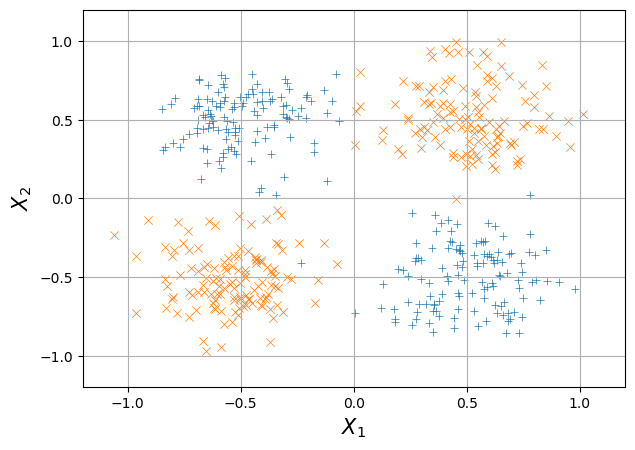

In [34]:
plot_dataset(xor_data)

In [35]:
def create_problem_xor():
    rand = random.Random()
    rand.seed(293891)
    # BEGIN YOUR CODE
    weights = {}
    for node in ["l11", "l12", "l13", "l14"]:
        for inputnode in ["x1", "x2", "bias"]:
            weights[".".join([node, inputnode])] = rand.normalvariate(0, 1) * 0.2

    weights["l2.sig1"] = rand.normalvariate(0, 1) * 0.2
    weights["l2.sig2"] = rand.normalvariate(0, 1) * 0.2
    weights["l2.sig3"] = rand.normalvariate(0, 1) * 0.2
    weights["l2.sig4"] = rand.normalvariate(0, 1) * 0.2
    weights["l2.bias"] = rand.normalvariate(0, 1) * 0.2
    layers = [
        [LinearUnit("l11", weights), LinearUnit("l12", weights), LinearUnit("l13", weights), LinearUnit("l14", weights)], #LinearUnit.new("l15", weights)],
        [Sigmoid("sig1"), Sigmoid("sig2"),Sigmoid("sig3"),Sigmoid("sig4")], #Sigmoid.new("sig5")],
        [LinearUnit("l2", weights)],
        [LogLoss()]
    ]

    connect(layers[0][0], layers[1][0])
    connect(layers[0][1], layers[1][1])
    connect(layers[0][2], layers[1][2])
    connect(layers[0][3], layers[1][3])
    connect(layers[1][0], layers[2][0])
    connect(layers[1][1], layers[2][0])
    connect(layers[1][2], layers[2][0])
    connect(layers[1][3], layers[2][0])
    connect(layers[2][0], layers[3][0])

    problem_xor = {"layers": layers, "weights": weights, "learning_rate": 1}
    #END YOUR CODE
    return problem_xor

In [36]:
def test_neural_network_xor(problem, examples):
    cumulative_loss = 0.0
    i = 0

    obj = NeuralNetwork(problem["layers"])
    sgd = StochasticGradientDescent(obj, problem["weights"], problem["learning_rate"])
    for epoch in range(500):
        for j in range(0, len(examples), 10):
            batch = examples[j : j + 20]    
            sgd.update(batch)
            cumulative_loss += obj.func(batch, sgd.weights)
            i += 1
            if i % 100 == 0:
                print("\t".join([i.__str__(), (cumulative_loss / i).__str__()]))
            if cumulative_loss / i < 0.3:
                break
        if cumulative_loss / i < 0.3:
            break

    predictions = obj.predict(examples)
    scores = [[score, 1 if examples[index]["label"] > 0 else 0] for index, score in enumerate(predictions)]
    auc = AUCMetric().apply(scores)
    print("AUC: %f" % auc)

    assert(cumulative_loss / i < 0.3)
    assert(auc > 0.9)
    return obj

trained_xor_model = test_neural_network_xor(create_problem_xor(), xor_data)

100	0.6931689946329159
200	0.6931596342961005
300	0.6931523465506623
400	0.6931458038926946
500	0.6931395906059663
600	0.6931334570998113
700	0.6931271938491672
800	0.693120577329602
900	0.6931133164472371
1000	0.6931049640927615
1100	0.6930947328273879
1200	0.6930810457547056
1300	0.6930602348089604
1400	0.6930217629320167
1500	0.6929235120458923
1600	0.6924997549197479
1700	0.6902692733232556
1800	0.6842753782219541
1900	0.669306963272383
2000	0.6466911399722958
2100	0.6233999836592367
2200	0.6012099262795232
2300	0.5804857096928386
2400	0.5612449254066089
2500	0.5434030112438888
2600	0.5268468747217749
2700	0.5114605611330928
2800	0.49713459154104456
2900	0.48376905681455223
3000	0.4712741820521181
3100	0.45956986368087516
3200	0.44858482330725097
3300	0.4382556621600981
3400	0.42852594016951523
3500	0.4193453302845818
3600	0.4106688643649163
3700	0.4024562711610695
3800	0.394671399980759
3900	0.3872817210554268
4000	0.38025789312761976
4100	0.373573389248204
4200	0.3672041726360962

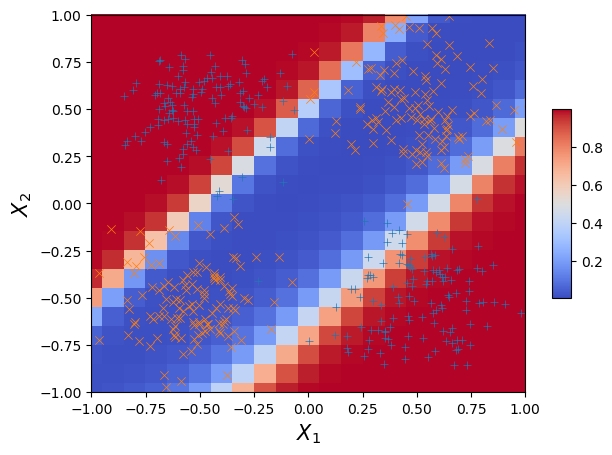

In [37]:
plot_decision_boundary(xor_data, trained_xor_model)

## Question 6.1 (5 points)
Using a 3-layer neural network achieve an $\log$ training loss of less than 0.2 on the concentric circles dataset. You will initialize a ```problem``` Hash with a weights initializer and the layers. You are free to choose the activation and any layers. We will standardize on the ```LogLoss``` for this dataset, which you will need to add. Don't forget to connect your nodes.

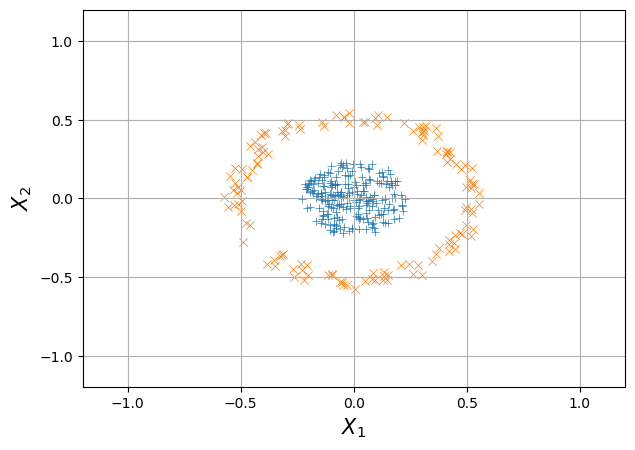

In [38]:
plot_dataset(concentric_circle_data)

In [39]:
def create_problem_concentric():
    # BEGIN YOUR CODE
    problem_concentric = create_problem_xor()
    # END YOUR CODE
    return problem_concentric

In [40]:
def test_neural_network_concentric(problem, examples):
    cumulative_loss = 0.0
    i = 0

    obj = NeuralNetwork(problem["layers"])
    sgd = StochasticGradientDescent(obj, problem["weights"], problem["learning_rate"])
    for epoch in range(500):
        for j in range(0, len(examples), 10):
            batch = examples[j : j + 20]    
            sgd.update(batch)
            cumulative_loss += obj.func(batch, sgd.weights)
            i += 1
            if i % 100 == 0:
                print("\t".join([i.__str__(), (cumulative_loss / i).__str__()]))
            if cumulative_loss / i < 0.4:
                break
        if cumulative_loss / i < 0.4:
            break

    predictions = obj.predict(examples)
    scores = [[score, 1 if examples[index]["label"] > 0 else 0] for index, score in enumerate(predictions)]
    auc = AUCMetric().apply(scores)
    print("AUC: %f" % auc)

    assert(cumulative_loss / i < 0.4)
    assert(auc > 0.9)
    return obj

trained_concentric_model = test_neural_network_concentric(create_problem_concentric(), concentric_circle_data)

100	0.6338196909582419
200	0.6340938767250048
300	0.6346965254445813
400	0.6348635380571733
500	0.634326942549404
600	0.6354821287786749
700	0.6354137496988681
800	0.6353857195675399
900	0.6357220317528294
1000	0.6359221042359151
1100	0.6360663186882481
1200	0.6362899091038078
1300	0.6365466954979969
1400	0.6366859183951651
1500	0.6365017933348059
1600	0.6370118742286671
1700	0.6370044987446629
1800	0.6369987817010784
1900	0.6371088991624042
2000	0.6371252327310191
2100	0.6370465288599123
2200	0.6369113900537187
2300	0.636405098535548
2400	0.6353602663829544
2500	0.6335362690817927
2600	0.6312585301368338
2700	0.6283668245447508
2800	0.6252792986756938
2900	0.6219629661335015
3000	0.6181769001609014
3100	0.61338231644299
3200	0.6073898018315501
3300	0.600383637449769
3400	0.5930678565482335
3500	0.5854514965945665
3600	0.5780321619088649
3700	0.5710394545855186
3800	0.564024396831641
3900	0.5573840011635015
4000	0.5511970373136522
4100	0.5450651664326533
4200	0.5392680463500692
4300	0.

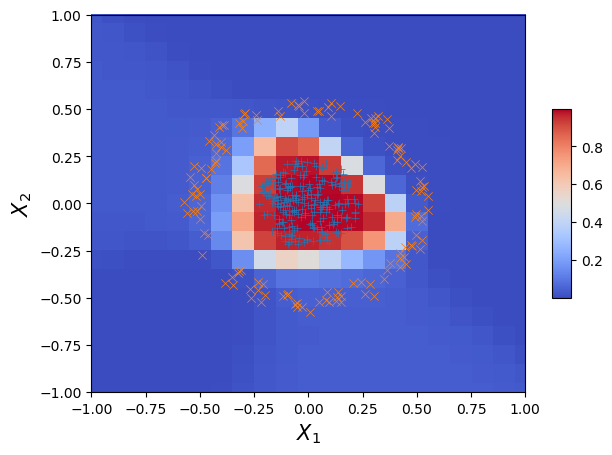

In [41]:
plot_decision_boundary(concentric_circle_data, trained_concentric_model)